In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
df =pd.read_csv('temperature_data.csv')
print(df.head())

   Day  Temperature
0    1     0.133553
1    2     0.061635
2    3     0.175963
3    4     0.302001
4    5     0.082970


In [4]:
temperature_data = df['Temperature']
print(type(temperature_data))

<class 'pandas.core.series.Series'>


In [5]:
temperature_data = df['Temperature'].values
print(type(temperature_data))
print(temperature_data)
print(len(temperature_data))

<class 'numpy.ndarray'>
[ 1.33553080e-01  6.16354178e-02  1.75963094e-01  3.02000633e-01
  8.29696522e-02  9.42503153e-02  3.43196993e-01  2.48034592e-01
  9.71245621e-02  2.40968148e-01  1.20270378e-01  1.31094645e-01
  2.34945912e-01 -3.65024057e-02 -8.05929456e-04  1.62546075e-01
  1.14401156e-01  2.99204973e-01  1.49796025e-01  9.44382200e-02
  4.82343917e-01  2.71251924e-01  3.20239311e-01  1.35109122e-01
  2.60897691e-01  3.57107878e-01  2.01936396e-01  4.12197225e-01
  2.94285625e-01  3.44751696e-01  3.13994096e-01  6.45431098e-01
  4.10555534e-01  2.83263792e-01  5.39191868e-01  2.80719734e-01
  4.77373047e-01  2.02272890e-01  2.94068932e-01  5.02869763e-01
  5.82644097e-01  5.16970626e-01  4.87881950e-01  4.71975924e-01
  3.25916274e-01  4.33496150e-01  4.75470760e-01  6.82271400e-01
  5.96467165e-01  3.27911161e-01  6.08909455e-01  5.23235340e-01
  4.92111797e-01  6.67991651e-01  7.29776445e-01  7.23370895e-01
  4.97809159e-01  5.73625345e-01  6.63758890e-01  7.54226854e-01
 

In [6]:
np.random.seed(42)
seq_length = 30
batch_size = 32

In [41]:
class TimeSeriesDataset(Dataset):
    def __init__(self,data,seq_length):
        self.data = data
        self.seq_length=seq_length

    def __len__(self):
        return len(self.data)-self.seq_length
    
    def __getitem__(self,i):
        x = self.data[i:i+self.seq_length]
        y = self.data [i+self.seq_length]
        return torch.tensor(x,dtype=torch.float32).unsqueeze(-1),torch.tensor(y,dtype=torch.float32)

#335 // 32 = 10 full batches → 10 * 32 = 320 samples
335 - 320 = 15 remaining → 1 final batch with 15 samples
If you only want batches of size 32, you can drop the last incomplete one using:


dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [66]:
dataset = TimeSeriesDataset(temperature_data,seq_length)
dataloader =DataLoader(dataset, batch_size = batch_size, shuffle=False)
print(dataloader)
print(len(dataset))  # Total number of samples


335


In [43]:
# Defines a custom PyTorch model by subclassing nn.Module
class Generator(nn.Module):
    # Constructor of the Generator class.
    # Calls the parent class nn.Module’s constructor.
    # input_dim: number of input features per time step.
    # output_dim: number of output features per time step.
    # seq_length: length of the input sequence.
    def __init__(self, input_dim, hidden_dim, output_dim, seq_length):
        super(Generator, self).__init__()
        self.hidden_dim = hidden_dim
        # Creates a 2-layer LSTM:
        # input_dim: size of each input vector per time step.
        # hidden_dim: number of features in the hidden state.
        # num_layers=2: this LSTM has 2 stacked layers.
        # batch_first=True: input/output tensors will be of shape (batch, seq_len, features).

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True) #(batch_size, seq_lenght, hidden_dim)
        # A fully connected (dense) layer that maps the LSTM output (of size hidden_dim)
        # to the desired output size per time step (output_dim).
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Defines how data flows through the model.
        # x is expected to have shape: (batch_size, seq_length, input_dim)
        
    def forward(self, x):  
        # Initializes the hidden and cell states for the LSTM.
        # LSTMs have two internal states at every time step:
        # Hidden state (h_t): short-term memory (what it's currently "thinking").
        # Cell state (c_t): long-term memory (what it's "remembering" over time).
        # Shape: (num_layers, batch_size, hidden_dim)
        # 2 corresponds to num_layers=2 from above.
        # x.size(0) is the batch size.
        # 📌 Note: These are initialized to zeros for each forward pass, which is okay for many use cases.
        h_0 = torch.zeros(2,x.size(0),self.hidden_dim)    # x.size(0) gives batch_size
        c_0 = torch.zeros(2,x.size(0),self.hidden_dim)
        #  Feeds the input x through the LSTM, along with the initial hidden and cell states.
        # lstm_out contains the output for each time step (shape: (batch_size, seq_len, hidden_dim)).
        # _ contains the final hidden and cell states (not used here)
        lstm_out,_ =self.lstm(x,(h_0,c_0))
        out = self.fc(lstm_out)
        return out
        


In [44]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True) #(batch_size, seq_lenght, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):  
        h_0 = torch.zeros(2,x.size(0),self.hidden_dim)  
        c_0 = torch.zeros(2,x.size(0),self.hidden_dim)
        lstm_out,_ =self.lstm(x,(h_0,c_0))
        out = self.fc(lstm_out[:,-1,:])
        return out
#        

In [45]:
#Parameters
input_dim = 1
output_dim = 1
hidden_dim = 64
num_epochs = 1500

#Initialize model
generator = Generator(input_dim, hidden_dim, output_dim, seq_length)
discriminator = Discriminator(input_dim, hidden_dim)

criterion = nn.BCEWithLogitsLoss()

OptimizerG = optim.Adam(generator.parameters(),lr=0.0001)
OptimizerD = optim.Adam(discriminator.parameters(), lr=0.0001)

In [49]:
# Training Loop

for epoch in range(num_epochs):
    g_loss_epoch =0
    d_loss_epoch =0
    

    for real_batch,_ in dataloader:
        batch_size = real_batch.size(0) 
        # print(batch_size)
        real_labels = torch.ones(batch_size,1)  #(32,1)
        fake_labels =  torch.zeros(batch_size,1)

        # Train the discriminator
        OptimizerD.zero_grad()

        real_output = discriminator(real_batch)
        d_loss_real = criterion(real_output,real_labels)
        
        noise = torch.randn(batch_size, seq_length, input_dim)
        fake_data = generator(noise)
        fake_output = discriminator(fake_data)
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = d_loss_real+ d_loss_fake
        d_loss.backward()
        OptimizerD.step()

        # Train Generator
        OptimizerG.zero_grad()
        noise = torch.randn(batch_size, seq_length, input_dim)
        fake_data = generator(noise)
        fake_output = discriminator(fake_data)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        OptimizerG.step()


        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()

    if epoch % 10 ==0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {d_loss_epoch/len(dataloader):.4f}, Loss G:  {g_loss_epoch/len(dataloader):.4f}")



Epoch [1/1500] Loss D: 1.3866, Loss G:  0.6930
Epoch [11/1500] Loss D: 1.3870, Loss G:  0.6935
Epoch [21/1500] Loss D: 1.3834, Loss G:  0.6937
Epoch [31/1500] Loss D: 1.2999, Loss G:  0.7809
Epoch [41/1500] Loss D: 1.4927, Loss G:  0.6890
Epoch [51/1500] Loss D: 1.2277, Loss G:  1.2199
Epoch [61/1500] Loss D: 1.3946, Loss G:  0.7241
Epoch [71/1500] Loss D: 1.3951, Loss G:  0.6933
Epoch [81/1500] Loss D: 1.3953, Loss G:  0.6810
Epoch [91/1500] Loss D: 1.3933, Loss G:  0.6764
Epoch [101/1500] Loss D: 1.3890, Loss G:  0.6763
Epoch [111/1500] Loss D: 1.3847, Loss G:  0.6775
Epoch [121/1500] Loss D: 1.3833, Loss G:  0.6782
Epoch [131/1500] Loss D: 1.3846, Loss G:  0.6795
Epoch [141/1500] Loss D: 1.3872, Loss G:  0.6830
Epoch [151/1500] Loss D: 1.3894, Loss G:  0.6885
Epoch [161/1500] Loss D: 1.3900, Loss G:  0.6946
Epoch [171/1500] Loss D: 1.3885, Loss G:  0.7003
Epoch [181/1500] Loss D: 1.3857, Loss G:  0.7045
Epoch [191/1500] Loss D: 1.3830, Loss G:  0.7059
Epoch [201/1500] Loss D: 1.3821

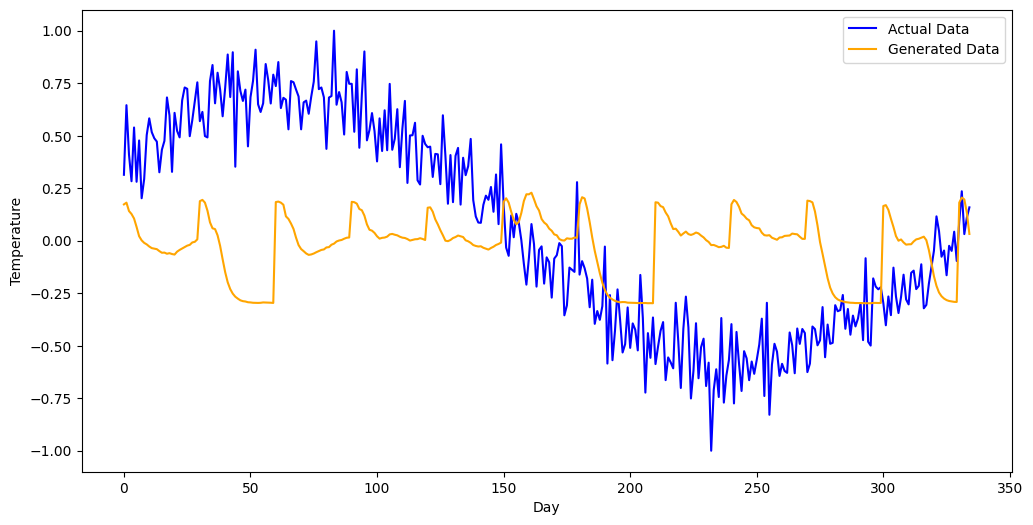

In [56]:
num_sequences = len(temperature_data) - seq_length
noise = torch.randn(num_sequences, seq_length,input_dim)
generated_data = generator(noise).detach().numpy().flatten()[:num_sequences]
actual_data = temperature_data[seq_length: seq_length+num_sequences]  #[30:365]

# plot the actual and generated data

plt.figure(figsize=(12,6))
plt.plot(actual_data,label='Actual Data', color='blue')
plt.plot(range(len(actual_data)),generated_data, label='Generated Data', color='orange')
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [65]:
mse = mean_squared_error(actual_data,generated_data)
mae = mean_absolute_error(actual_data, generated_data)
correlation = np.corrcoef(actual_data, generated_data)[0,1]

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Correllation Coeff: {correlation:.4f}")



Mean Squared Error: 0.2652
Mean Absolute Error: 0.4394
Correllation Coeff: 0.0429
